In [ ]:
from tensorflow.keras.models import Sequential

📥 Loading data...
🔁 Creating sequences...
✅ Input shape to LSTM: (17731, 30, 24)
✅ Target shape: (17731, 1)


d:\turbofan_RUL\Turbofan-Engine-Remaining_Useful_Life\tf_rul\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        22,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,233 (137.63 KB)

 Trainable params: 35,233 (137.63 KB)

 Non-trainable params: 0 (0.00 B)

🚀 Training LSTM model with asymmetric PHM08 loss...
Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 98143072.0000 - mean_absolute_error: 87.3270 - val_loss: 82701952.0000 - val_mean_absolute_error: 97.9332
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 64393912.0000 - mean_absolute_error: 81.6007 - val_loss: 69181888.0000 - val_mean_absolute_error: 95.8695
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 47565720.0000 - mean_absolute_error: 80.6471 - val_loss: 59640056.0000 - val_mean_absolute_error: 94.1984
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 42382556.0000 - mean_absolute_error: 78.8333 - val_loss: 52416320.0000 - val_mean_absolute_error: 92.7781
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 49044548.0000 - mean_absolute_error: 78.6192 - val_loss: 46059420.0000 - val_mean_absolute_error: 91.3851
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 45219072.0000 - mean_absolute_error: 76.9626 - val_l

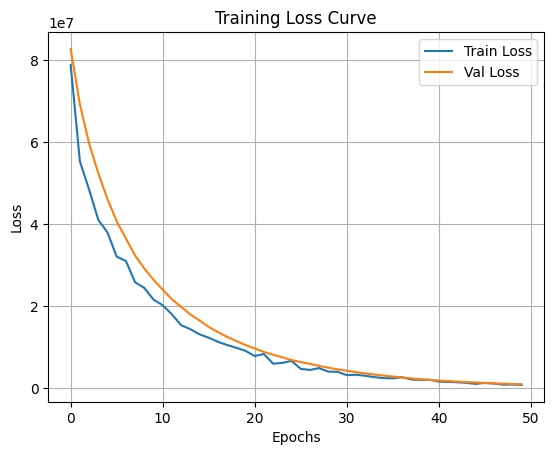

💾 Model saved as 'rul_lstm_phm08.h5'


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
import os

# -----------------------------
# 1. Constants and Configs
# -----------------------------
SEQUENCE_LENGTH = 30
DATA_PATH = "CMaps/train_FD001.txt"
OP_COLS = ["op1", "op2", "op3"]
SENSOR_COLS = [f"sensor{i}" for i in range(1, 22)]  # sensors 1 to 21
ALL_COLUMNS = ["unit", "time_cycles"] + OP_COLS + SENSOR_COLS


# -----------------------------
# 2. Custom Asymmetric PHM08 Loss
# -----------------------------
def asymmetric_loss(y_true, y_pred):
    error = y_pred - y_true
    mask = K.cast(K.less(error, 0.0), K.floatx())
    loss_early = K.exp(-error / 13.0) - 1.0
    loss_late = K.exp(error / 10.0) - 1.0
    return K.mean(mask * loss_early + (1 - mask) * loss_late)


# -----------------------------
# 3. Load and Preprocess Data
# -----------------------------
def load_and_preprocess_data(filepath):
    df = pd.read_csv(filepath, sep="\s+", header=None, names=ALL_COLUMNS)

    # Compute RUL
    df["max_cycle"] = df.groupby("unit")["time_cycles"].transform("max")
    df["RUL"] = df["max_cycle"] - df["time_cycles"]
    df.drop("max_cycle", axis=1, inplace=True)

    return df


def normalize(df, feature_columns):
    scaler = MinMaxScaler()
    df[feature_columns] = scaler.fit_transform(df[feature_columns])
    return df, scaler


# -----------------------------
# 4. Sequence Builder
# -----------------------------
def create_sequences(df, sequence_length, feature_columns):
    sequences = []
    rul_values = []

    for unit in df["unit"].unique():
        unit_df = df[df["unit"] == unit]
        unit_df = unit_df.reset_index(drop=True)
        for i in range(len(unit_df) - sequence_length + 1):
            seq = unit_df.loc[i : i + sequence_length - 1, feature_columns].values
            label = unit_df.loc[i + sequence_length - 1, "RUL"]
            sequences.append(seq)
            rul_values.append(label)

    X = np.array(sequences)
    y = np.array(rul_values).reshape(-1, 1)

    return X, y


# -----------------------------
# 5. Build LSTM Model
# -----------------------------
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(LSTM(32))
    model.add(Dropout(0.3))
    model.add(Dense(1))

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=asymmetric_loss,
        metrics=[tf.keras.metrics.MeanAbsoluteError()],
    )
    return model


# -----------------------------
# 6. Train the Model
# -----------------------------
def train_model(model, X_train, y_train, epochs=50, batch_size=64):
    history = model.fit(
        X_train,
        y_train,
        validation_split=0.2,
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
    )
    return history


# -----------------------------
# 7. Plot Training History
# -----------------------------
def plot_loss(history):
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.legend()
    plt.grid()
    plt.show()


# -----------------------------
# 8. Main Runner
# -----------------------------
def main():
    # Step 1: Load data
    print("📥 Loading data...")
    df = load_and_preprocess_data(DATA_PATH)

    # Step 2: Normalize features
    feature_columns = OP_COLS + SENSOR_COLS
    df, scaler = normalize(df, feature_columns)

    # Step 3: Create sequences for LSTM
    print("🔁 Creating sequences...")
    X, y = create_sequences(df, SEQUENCE_LENGTH, feature_columns)

    print(f"✅ Input shape to LSTM: {X.shape}")  # Should be (samples, 30, features)
    print(f"✅ Target shape: {y.shape}")  # Should be (samples, 1)

    # Step 4: Build model
    model = build_lstm_model(input_shape=(SEQUENCE_LENGTH, len(feature_columns)))
    model.summary()

    # Step 5: Train
    print("🚀 Training LSTM model with asymmetric PHM08 loss...")
    history = train_model(model, X, y)

    # Step 6: Visualize
    plot_loss(history)

    # Step 7: Save
    model.save("rul_lstm_phm08.h5")
    print("💾 Model saved as 'rul_lstm_phm08.h5'")


# -----------------------------
# 9. Run Main
# -----------------------------
if __name__ == "__main__":
    main()

NameError: name 'X' is not defined